In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
import datetime
from dateutil.relativedelta import relativedelta
import pickle as pck

In [2]:
bitcoin = pd.read_csv("../data/bitcoin.csv")

In [3]:
bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4437 entries, 0 to 4436
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Fecha     4437 non-null   object
 1   Último    4437 non-null   object
 2   Apertura  4437 non-null   object
 3   Máximo    4437 non-null   object
 4   Mínimo    4437 non-null   object
 5   Vol.      4437 non-null   object
 6   % var.    4437 non-null   object
dtypes: object(7)
memory usage: 242.8+ KB


In [4]:
bitcoin.describe()

Fecha Último Apertura Máximo Mínimo   Vol. % var.
count         4437   4437     4437   4437   4437   4437   4437
unique        4437   3485     3478   3470   3480   3965   1515
top     09.09.2022    0,1      0,1    0,1    0,1  1,05M  0,00%
freq             1    100      100     97    101      6    425

In [5]:
bitcoin.head()

Fecha    Último  Apertura    Máximo    Mínimo     Vol.  % var.
0  09.09.2022  20.742,8  19.318,8  20.743,7  19.294,1  359,40K   7,38%
1  08.09.2022  19.317,4  19.281,5  19.444,7  19.034,5  291,43K   0,19%
2  07.09.2022  19.281,5  18.786,3  19.445,9  18.548,4  319,10K   2,64%
3  06.09.2022  18.786,4  19.793,4  20.169,3  18.723,3  402,43K  -5,09%
4  05.09.2022  19.793,1  19.999,9  20.042,9  19.650,7  238,71K  -1,03%

We can see that "Fecha" is in descending order, so we need to change that

In [6]:
bitcoin.describe()

Fecha Último Apertura Máximo Mínimo   Vol. % var.
count         4437   4437     4437   4437   4437   4437   4437
unique        4437   3485     3478   3470   3480   3965   1515
top     09.09.2022    0,1      0,1    0,1    0,1  1,05M  0,00%
freq             1    100      100     97    101      6    425

In [7]:
fig = px.line(bitcoin, x="Fecha", y="Máximo")
fig.show()

In this plot (which it shows the fluctuation of Bitcoin price in a strange way, due to the column "Fecha" being in descending order) see that a great amount of values don't show much change for a long period of time. We're not interested in those values because they can only tell us that Bitcoin wasn´'t what it is now. We'll get rid of them later, after cleaning the data.



In [8]:
bitcoin.columns = ["date", "last", "open", "high", "low", "vol", "var_%"]

In [9]:
bitcoin.head()

date      last      open      high       low      vol   var_%
0  09.09.2022  20.742,8  19.318,8  20.743,7  19.294,1  359,40K   7,38%
1  08.09.2022  19.317,4  19.281,5  19.444,7  19.034,5  291,43K   0,19%
2  07.09.2022  19.281,5  18.786,3  19.445,9  18.548,4  319,10K   2,64%
3  06.09.2022  18.786,4  19.793,4  20.169,3  18.723,3  402,43K  -5,09%
4  05.09.2022  19.793,1  19.999,9  20.042,9  19.650,7  238,71K  -1,03%

In [10]:
bitcoin["date"].describe()

count           4437
unique          4437
top       09.09.2022
freq               1
Name: date, dtype: object

In [11]:
bitcoin["date"]= pd.to_datetime(bitcoin["date"], dayfirst=True)

In [12]:
bitcoin.head()

date      last      open      high       low      vol   var_%
0 2022-09-09  20.742,8  19.318,8  20.743,7  19.294,1  359,40K   7,38%
1 2022-09-08  19.317,4  19.281,5  19.444,7  19.034,5  291,43K   0,19%
2 2022-09-07  19.281,5  18.786,3  19.445,9  18.548,4  319,10K   2,64%
3 2022-09-06  18.786,4  19.793,4  20.169,3  18.723,3  402,43K  -5,09%
4 2022-09-05  19.793,1  19.999,9  20.042,9  19.650,7  238,71K  -1,03%

In [13]:
bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4437 entries, 0 to 4436
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    4437 non-null   datetime64[ns]
 1   last    4437 non-null   object        
 2   open    4437 non-null   object        
 3   high    4437 non-null   object        
 4   low     4437 non-null   object        
 5   vol     4437 non-null   object        
 6   var_%   4437 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 242.8+ KB


In [14]:
num = bitcoin.drop("date", axis = 1)

In [15]:
num.head()

last      open      high       low      vol   var_%
0  20.742,8  19.318,8  20.743,7  19.294,1  359,40K   7,38%
1  19.317,4  19.281,5  19.444,7  19.034,5  291,43K   0,19%
2  19.281,5  18.786,3  19.445,9  18.548,4  319,10K   2,64%
3  18.786,4  19.793,4  20.169,3  18.723,3  402,43K  -5,09%
4  19.793,1  19.999,9  20.042,9  19.650,7  238,71K  -1,03%

In the cell below we replace the letters and symbols that we don't want

In [16]:
for i in num:
    for j in range(len(num)):
        num[i][j] = num[i][j].replace(".", "")
        num[i][j] = num[i][j].replace(",", ".")
        if "%" in num[i][j]:
            num[i][j] = num[i][j].replace("%", "")
        elif "K" in num[i][j]:
            num[i][j] = float(num[i][j].replace("K", ""))
        elif "M" in num[i][j]:
            num[i][j] = float(num[i][j].replace("M", "")) * 1000
            if num[i][j] > 15:
                num[i][j] = num[i][j] / 1000
        elif "B" in num[i][j]:
            num[i][j] = float(num[i][j].replace("B", "")) * 1000
        elif num[i][j] == "-":
            num[i][j] = 0
        else:
            pass

In [17]:
num.head()

last     open     high      low     vol  var_%
0  20742.8  19318.8  20743.7  19294.1   359.4   7.38
1  19317.4  19281.5  19444.7  19034.5  291.43   0.19
2  19281.5  18786.3  19445.9  18548.4   319.1   2.64
3  18786.4  19793.4  20169.3  18723.3  402.43  -5.09
4  19793.1  19999.9  20042.9  19650.7  238.71  -1.03

In [18]:
num = num.astype(float)

In [19]:
bitcoin[["last", "open", "high", "low", "vol", "var_%"]] = num

Now we sort the dates in descending order and take out the useless values

In [20]:
bitcoin = bitcoin.sort_values(by='date').reset_index(drop = True)

In [21]:
bitcoin = bitcoin[bitcoin["date"] >= "2012-01-01"]

In [22]:
bitcoin = bitcoin.set_index("date")

In [23]:
bitcoin.insert(loc = 0, column = "date", value = bitcoin.index)

In [24]:
bitcoin

date     last     open     high      low     vol  var_%
date                                                                    
2012-01-01 2012-01-01      5.3      4.7      5.5      4.6  108.51  11.65
2012-01-02 2012-01-02      5.2      5.3      5.5      4.8   69.15  -0.95
2012-01-03 2012-01-03      4.9      5.2      5.3      4.7  125.17  -6.51
2012-01-04 2012-01-04      5.6      4.9      5.7      4.8  131.17  14.14
2012-01-05 2012-01-05      6.9      5.6      7.2      5.6  182.33  24.78
...               ...      ...      ...      ...      ...     ...    ...
2022-09-05 2022-09-05  19793.1  19999.9  20042.9  19650.7  238.71  -1.03
2022-09-06 2022-09-06  18786.4  19793.4  20169.3  18723.3  402.43  -5.09
2022-09-07 2022-09-07  19281.5  18786.3  19445.9  18548.4  319.10   2.64
2022-09-08 2022-09-08  19317.4  19281.5  19444.7  19034.5  291.43   0.19
2022-09-09 2022-09-09  20742.8  19318.8  20743.7  19294.1  359.40   7.38

[3905 rows x 7 columns]

Now we have the data cleaned and date column in correct order. 
Next thing is to check if the dates follows the same frequency.

In [25]:
bit_2 = bitcoin.copy()

bit_2['date_shift'] = bit_2['date'].shift()  

In [26]:
bit_2.head()

date  last  open  high  low     vol  var_% date_shift
date                                                                  
2012-01-01 2012-01-01   5.3   4.7   5.5  4.6  108.51  11.65        NaT
2012-01-02 2012-01-02   5.2   5.3   5.5  4.8   69.15  -0.95 2012-01-01
2012-01-03 2012-01-03   4.9   5.2   5.3  4.7  125.17  -6.51 2012-01-02
2012-01-04 2012-01-04   5.6   4.9   5.7  4.8  131.17  14.14 2012-01-03
2012-01-05 2012-01-05   6.9   5.6   7.2  5.6  182.33  24.78 2012-01-04

In [27]:
bit_2['diff'] = bit_2['date'] - bit_2['date_shift']

In [28]:
bit_2.head()

date  last  open  high  low     vol  var_% date_shift   diff
date                                                                         
2012-01-01 2012-01-01   5.3   4.7   5.5  4.6  108.51  11.65        NaT    NaT
2012-01-02 2012-01-02   5.2   5.3   5.5  4.8   69.15  -0.95 2012-01-01 1 days
2012-01-03 2012-01-03   4.9   5.2   5.3  4.7  125.17  -6.51 2012-01-02 1 days
2012-01-04 2012-01-04   5.6   4.9   5.7  4.8  131.17  14.14 2012-01-03 1 days
2012-01-05 2012-01-05   6.9   5.6   7.2  5.6  182.33  24.78 2012-01-04 1 days

In [29]:
bit_2[bit_2['diff'] != '1 days'].index 

DatetimeIndex(['2012-01-01'], dtype='datetime64[ns]', name='date', freq=None)

We see there are no values with a "diff" different from 1 "days", so we can say all values are following a daily frequency.
The [0] mis expected, since there is no value previous to the first one. 

We plot again tha data to see how it has changed.

In [30]:
fig = px.line(bitcoin, x="date", y="last")
fig.show()

There are many differences from the first one, but still, there is a big tail at the beginning that we don't need

In [31]:
bitcoin = (bitcoin[bitcoin["date"] >= "2017-01-01"])
bitcoin.head()

date    last    open    high     low     vol  var_%
date                                                                
2017-01-01 2017-01-01   995.4   963.4  1001.6   956.1   41.15   3.33
2017-01-02 2017-01-02  1017.0   995.4  1031.7   990.2   64.95   2.17
2017-01-03 2017-01-03  1033.3  1017.0  1035.5  1006.5   54.79   1.60
2017-01-04 2017-01-04  1135.4  1033.3  1148.5  1022.3  156.27   9.88
2017-01-05 2017-01-05   989.3  1135.4  1150.6   874.5  240.01 -12.86

In [32]:
fig = px.line(bitcoin, x="date", y="last")
fig.show()

Now it's better

In [33]:
bitcoin_17 = bitcoin[bitcoin["date"] < "2018-01-01"]
bitcoin_18 = bitcoin[(bitcoin["date"] > "2018-01-01") & (bitcoin["date"] < "2019-01-01")]
bitcoin_19 = bitcoin[(bitcoin["date"] > "2019-01-01") & (bitcoin["date"] < "2020-01-01")]
bitcoin_20 = bitcoin[(bitcoin["date"] > "2020-01-01") & (bitcoin["date"] < "2021-01-01")]
bitcoin_21 = bitcoin[(bitcoin["date"] > "2021-01-01") & (bitcoin["date"] < "2022-01-01")]
bitcoin_22 = bitcoin[(bitcoin["date"] > "2022-01-01")]

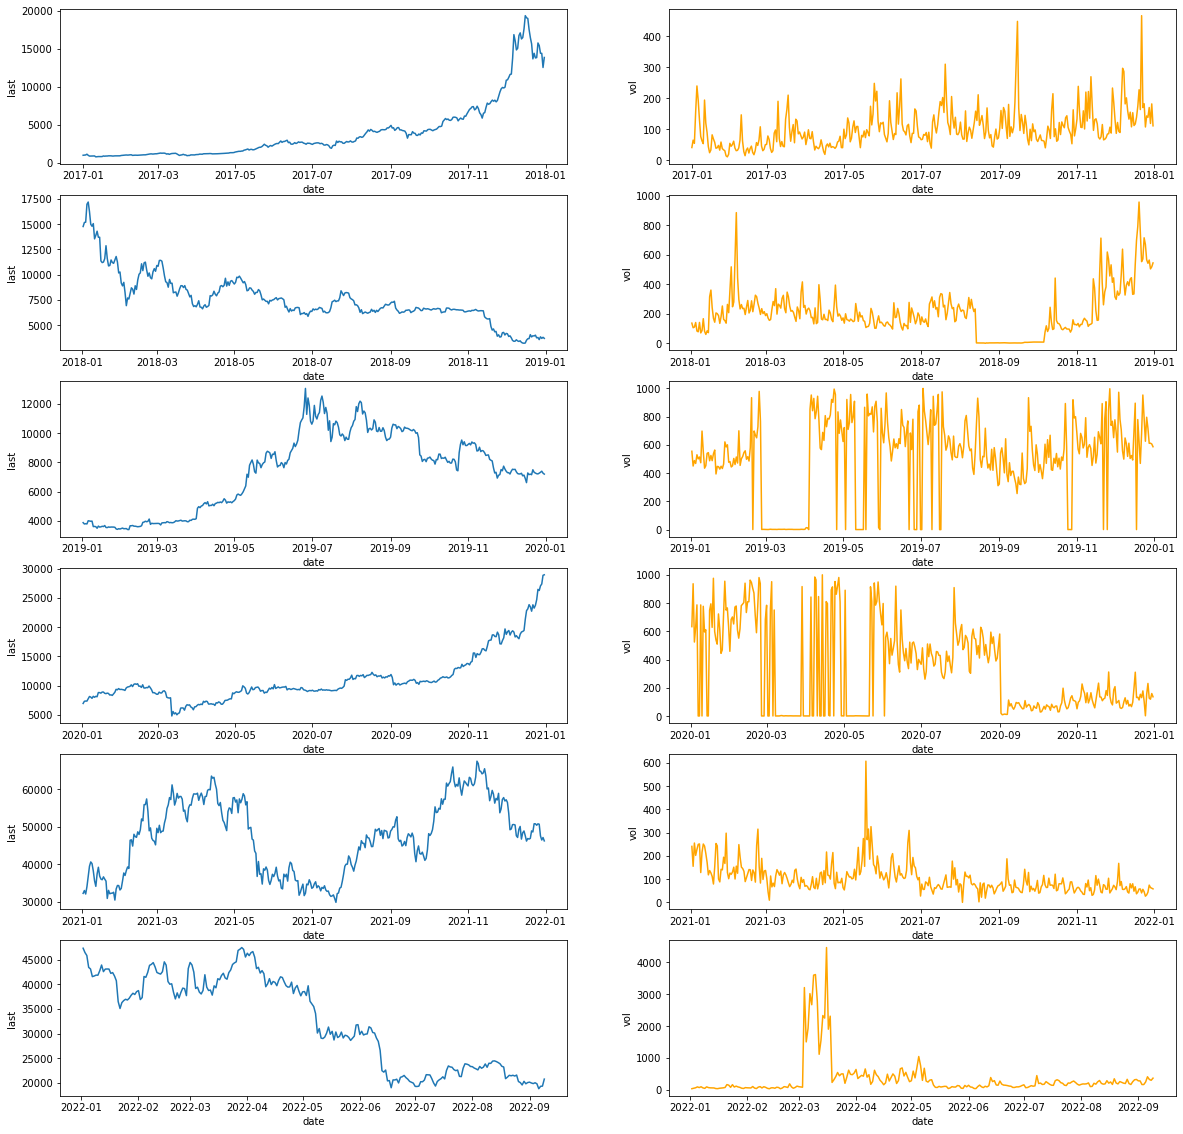

In [34]:
fig, axes = plt.subplots(6, 2, figsize = (20, 20))

sns.lineplot(data = bitcoin_17, y = "last", x = "date", ax = axes[0, 0])
sns.lineplot(data = bitcoin_17, y = "vol", x = "date", color = "orange", ax = axes[0, 1])
sns.lineplot(data = bitcoin_18, y = "last", x = "date", ax = axes[1, 0])
sns.lineplot(data = bitcoin_18, y = "vol", x = "date", color = "orange", ax = axes[1, 1])
sns.lineplot(data = bitcoin_19, y = "last", x = "date", ax = axes[2, 0])
sns.lineplot(data = bitcoin_19, y = "vol", x = "date", color = "orange", ax = axes[2, 1])
sns.lineplot(data = bitcoin_20, y = "last", x = "date", ax = axes[3, 0])
sns.lineplot(data = bitcoin_20, y = "vol", x = "date", color = "orange", ax = axes[3, 1])
sns.lineplot(data = bitcoin_21, y = "last", x = "date", ax = axes[4, 0])
sns.lineplot(data = bitcoin_21, y = "vol", x = "date", color = "orange", ax = axes[4, 1])
sns.lineplot(data = bitcoin_22, y = "last", x = "date", ax = axes[5, 0])
sns.lineplot(data = bitcoin_22, y = "vol", x = "date", color = "orange", ax = axes[5, 1])

plt.show()


In the plots above we see the price of bitcoin during each year from 2017 to the present day and the volume of transactiones made in the same period. On the left side, the prices, we for the last two years more fluctiation and respresenting data for the predictions. On the right side, the volumes, show a higher number of transactions, at least more constant in the past two years. Also we can see that each peak of transactions are result of a drop on the prices or significant increase. 

In [35]:
bitcoin.shape

(2078, 7)

In [36]:
bitcoin.to_csv('../data/clean_data.csv')

We are going to use the values from column "last" to predict the future results.

In [37]:
bitcoin_last = bitcoin[["last"]]

In [38]:
bitcoin_last.head()

last
date              
2017-01-01   995.4
2017-01-02  1017.0
2017-01-03  1033.3
2017-01-04  1135.4
2017-01-05   989.3

#### STATIONARITY

In [39]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags = "auto") 
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [40]:
adf_test(bitcoin_last["last"])

Results of Dickey-Fuller Test:
Test Statistic                   -1.510124
p-value                           0.528497
#Lags Used                       24.000000
Number of Observations Used    2053.000000
Critical Value (1%)              -3.433539
Critical Value (5%)              -2.862949
Critical Value (10%)             -2.567520
dtype: float64


From adf_test we see there is no stationarity. The p-value returned is higher than the significance level o.o5, and Test Statistic is also higher than the Critical Value 2.86. Therefore we accept the null hypothesis: TS has no Stationarity

In [41]:
kpss_test(bitcoin_last["last"])

Results of KPSS Test:
Test Statistic            4.678438
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




For the kpss_test we see p-value lower than significance level 0.05. But a higher Test Statistic: 4.68 than Critical Value: 0.46.
Being the H0: TS Stationarity

#### Decomposing

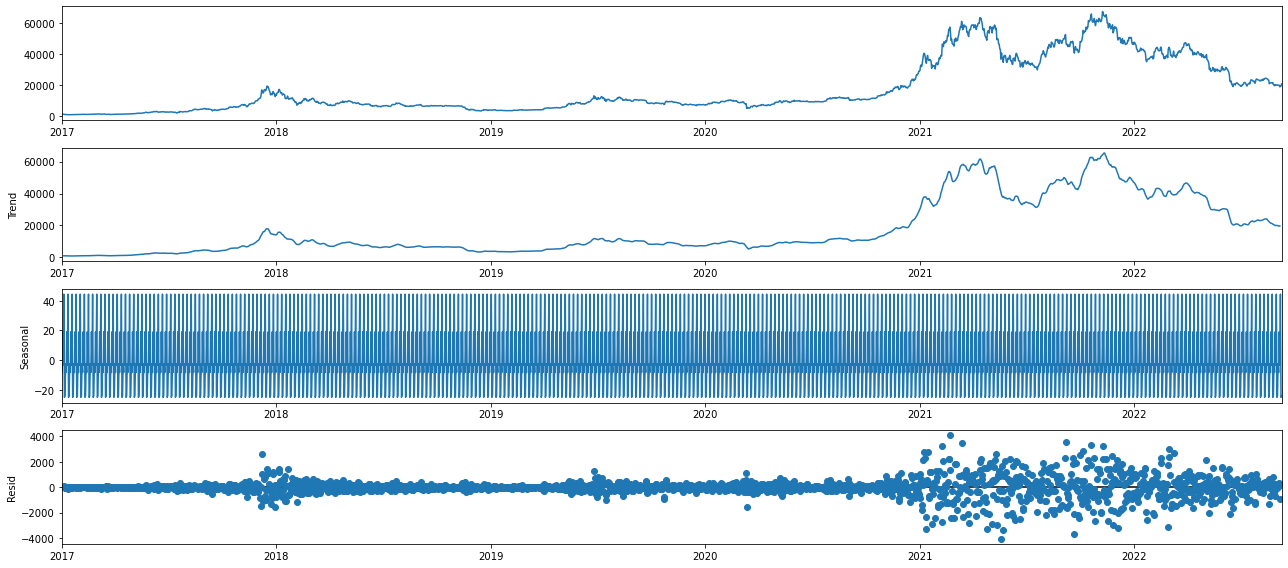

In [42]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(bitcoin_last, model='additive')
fig = decomposition.plot()
plt.show()

For the whole data we see possible seasonality


We'll check for the years 21 and 22 only, so we can see in more detail.

In [43]:
bitcoin_21_22 = bitcoin[bitcoin["date"] >= "2021-01-01"]

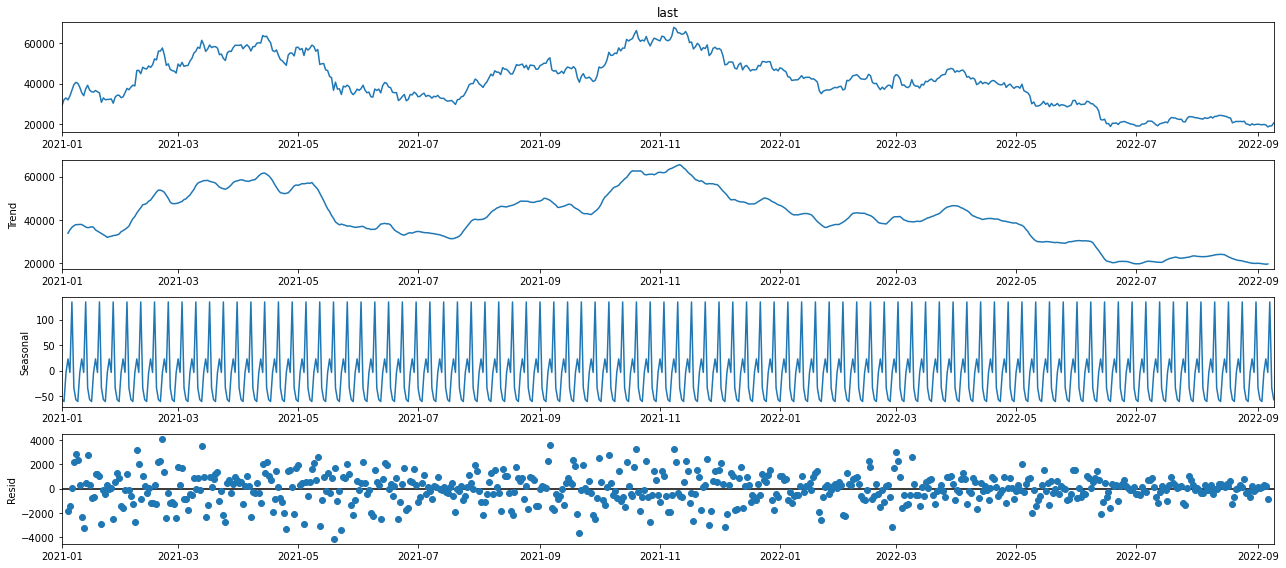

In [44]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(bitcoin_21_22["last"], model='additive')
fig = decomposition.plot()
plt.show()

We don't see Seasonality in this dataset. The Seasonal plot shows a cycle behaviour, but analysing the whole, we can't say there is a pattern in prices.

#### ACF PACF

In the cell below we check for ACF and PACF; autocorrelation and partial autocorrelation.

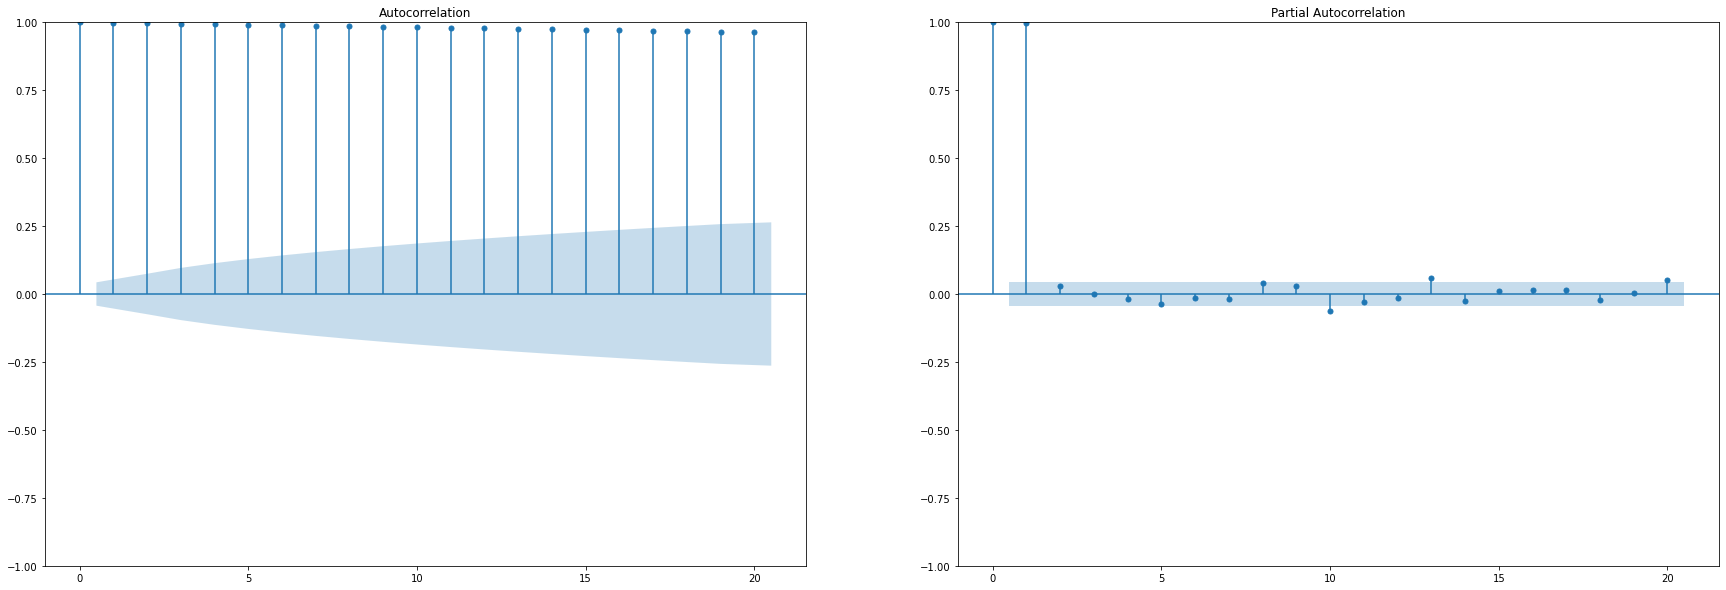

In [45]:
fig, axes = plt.subplots(1, 2, figsize= (30, 10))

fig = sm.graphics.tsa.plot_acf(bitcoin_last['last'],
                               lags = 20,                               
                               ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(bitcoin_last['last'], lags = 20, 
                                ax=axes[1], method = "ywm")

By looking at the plots we see a high Autocorrelation, meaning that each values is highly correlated to the previous one. 

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

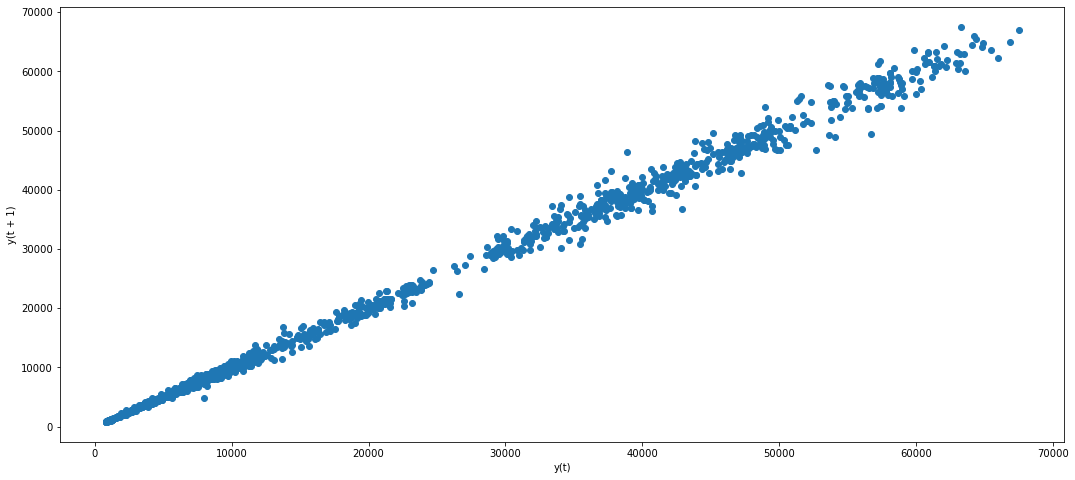

In [46]:
pd.plotting.lag_plot(bitcoin_last["last"])

On the plot above we can almost see a straight line. This tells us that the previous value can be used to predict the next one, to do so, AR(1) model is the one to use

In [47]:
bitcoin_21_22 = bitcoin_21_22[["date", "last"]]

In [48]:
import math 

max_train = math.ceil(len(bitcoin_21_22) * 0.80)  
max_train

494

In [49]:
train = bitcoin_21_22.iloc[:max_train,:]['last']
test  = bitcoin_21_22.iloc[max_train:,:]['last']

In [50]:
test

date
2022-05-10    31007.5
2022-05-11    29068.2
2022-05-12    28976.0
2022-05-13    29284.4
2022-05-14    30080.4
               ...   
2022-09-05    19793.1
2022-09-06    18786.4
2022-09-07    19281.5
2022-09-08    19317.4
2022-09-09    20742.8
Name: last, Length: 123, dtype: float64

#### AR

In [51]:

AR_model_1 = AutoReg(bitcoin_21_22["last"], lags = 1)
AR_fit_1 = AR_model_1.fit()

AR_predictions_1 = AR_fit_1.predict(start = len(train), end=len(train)+len(test)-1, dynamic=False)

print(AR_fit_1.params)

const      313.833202
last.L1      0.992079
dtype: float64


C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [52]:
AR_predictions_1

2022-05-10    30170.449850
2022-05-11    31075.721911
2022-05-12    29151.783162
2022-05-13    29060.313481
2022-05-14    29366.270636
                  ...     
2022-09-05    20155.313425
2022-09-06    19950.151493
2022-09-07    18951.425593
2022-09-08    19442.603892
2022-09-09    19478.219527
Freq: D, Length: 123, dtype: float64

In [53]:
test = pd.DataFrame(test)
test["AR_predictions_1"] = AR_predictions_1
test["AR_res"] = AR_fit_1.resid
test.head()

last  AR_predictions_1       AR_res
date                                              
2022-05-10  31007.5      30170.449850   837.050150
2022-05-11  29068.2      31075.721911 -2007.521911
2022-05-12  28976.0      29151.783162  -175.783162
2022-05-13  29284.4      29060.313481   224.086519
2022-05-14  30080.4      29366.270636   714.129364

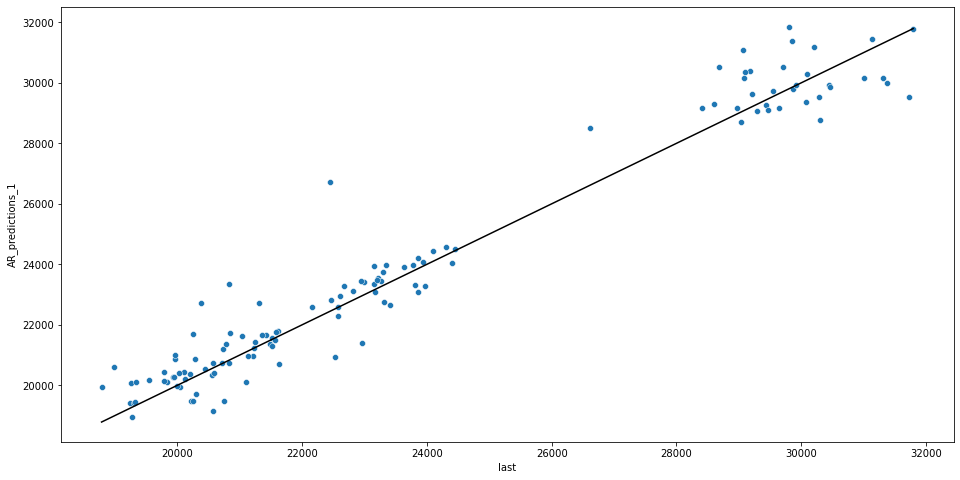

In [54]:
fig, ax = plt.subplots(1,figsize=(16,8))
sns.scatterplot(data = test, y = "AR_predictions_1", x = "last");
sns.lineplot(data= test, x = 'last', y = 'last',color = 'black');
plt.show()

We that the majority of the predicted values follow the patern of the original values 

In [55]:
future_pred = AR_fit_1.predict(start = "2022-09-10", end = "2022-09-29", dynamic=False) 

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.



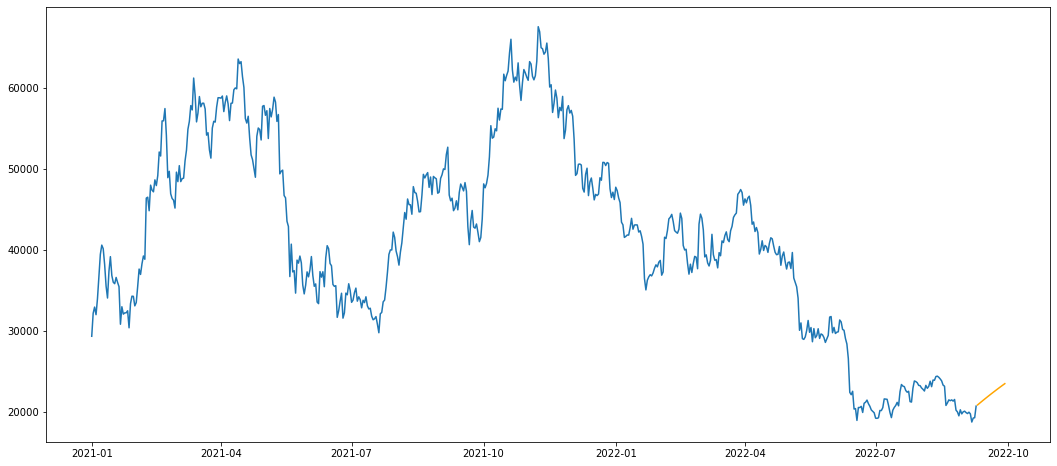

In [56]:
plt.plot(bitcoin_21_22["last"])
plt.plot(future_pred, color='orange')
plt.show()

In orange we see the predicted values for bitcoin. As we used an AutoReg model the output is a linear plot, showing, in this case, an ascendant trend. 

#### ARIMA model

##### Ckecking fot Stationarity between 2021-22

In [57]:
adf_test(bitcoin_21_22["last"])

Results of Dickey-Fuller Test:
Test Statistic                  -1.426083
p-value                          0.569710
#Lags Used                       0.000000
Number of Observations Used    616.000000
Critical Value (1%)             -3.441010
Critical Value (5%)             -2.866243
Critical Value (10%)            -2.569275
dtype: float64


From adf_test we see there is no stationarity. The p-value returned o.57 is higher than the significance level o.o5, and Test Statistic -1.43 is also higher than the Critical Value -2.86. Therefore we accept the null hypothesis: TS has no Stationarity

For ARIMA(p,d,q) model we need Stationary data, in this case we don't have it, thats why we need to apply differencing segment of ARIMA so we can have stationary data. 

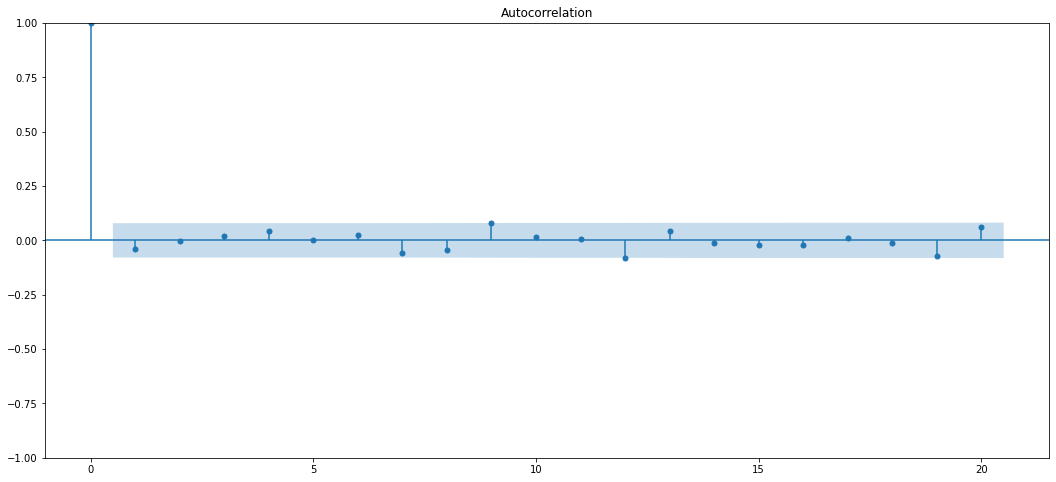

In [58]:
sm.graphics.tsa.plot_acf(bitcoin_21_22['last'].diff()[1:],
                               lags = 20)
plt.show()

We see that differentiating once is enough to deal with lack of stationarity. d = 1.

We also know that p = 1 from the autocorrelation before, and also it was the value we gave to the AR(1) model.
We just need the value for q so we can fit the model. 

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



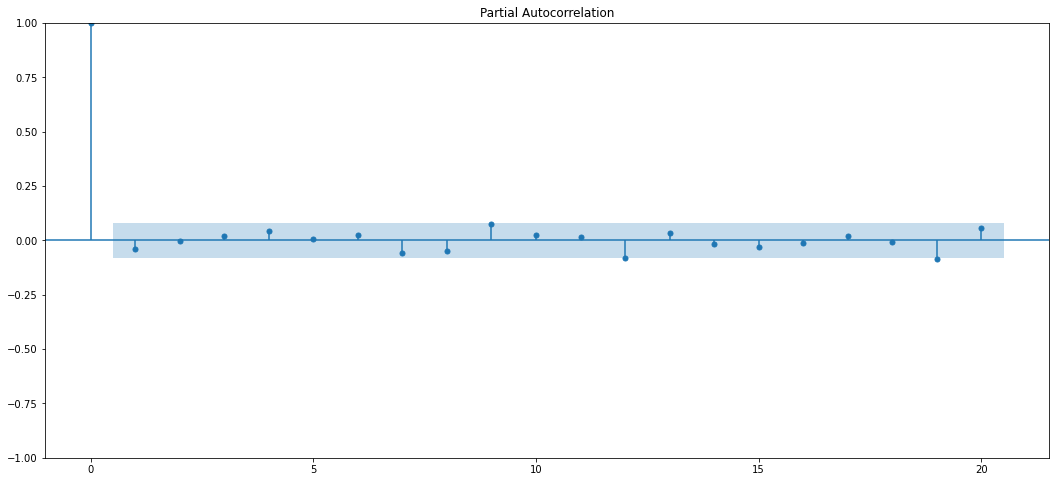

In [59]:
sm.graphics.tsa.plot_pacf(bitcoin_21_22['last'].diff()[1:],
                               lags = 20)
plt.show()

For this ARIMA the parameters are: 1

In [60]:
ARIMA_model1 = ARIMA(bitcoin_21_22["last"], order = (1, 1, 1), freq ="D")
ARIMA_fit_1 = ARIMA_model1.fit()
ARIMA_fit_1.summary()

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   last   No. Observations:                  617
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5440.221
Date:                Tue, 13 Sep 2022   AIC                          10886.442
Time:                        16:06:19   BIC                          10899.711
Sample:                    01-01-2021   HQIC                         10891.601
                         - 09-09-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0231      9.988     -0.002      0.998     -19.599      19.553
ma.L1          0.0193      9.989      0.002      0.998     -19.560      19.598
sigma2      2.736e+06   1.09e+05     25.168      0.000    2.52e+06    2.95e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):               124.37
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
with open("../models/ARIMA_model1.pkl", "wb") as file:
    pck.dump(ARIMA_model1,file)

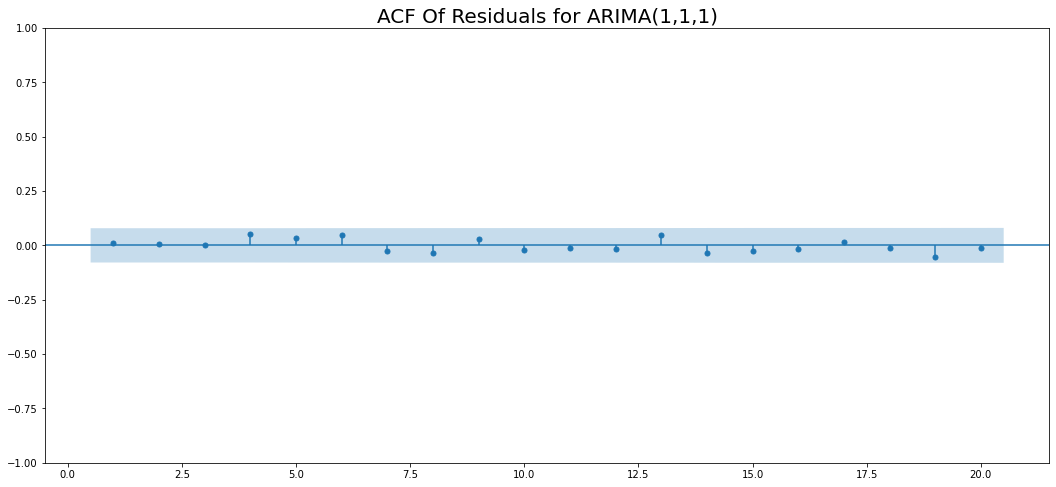

In [62]:
bitcoin_21_22["res_ARIMA_1"] = ARIMA_fit_1.resid
sgt.plot_acf(bitcoin_21_22["res_ARIMA_1"], zero = False, lags = 20)
plt.title("ACF Of Residuals for ARIMA(1,1,1)", size = 20)
plt.show()

In [63]:
ARIMA_predictions_1 = ARIMA_fit_1.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)


In [64]:
bitcoin_21_22["ARIMA_predictions_1"] = ARIMA_predictions_1

<AxesSubplot:xlabel='date'>

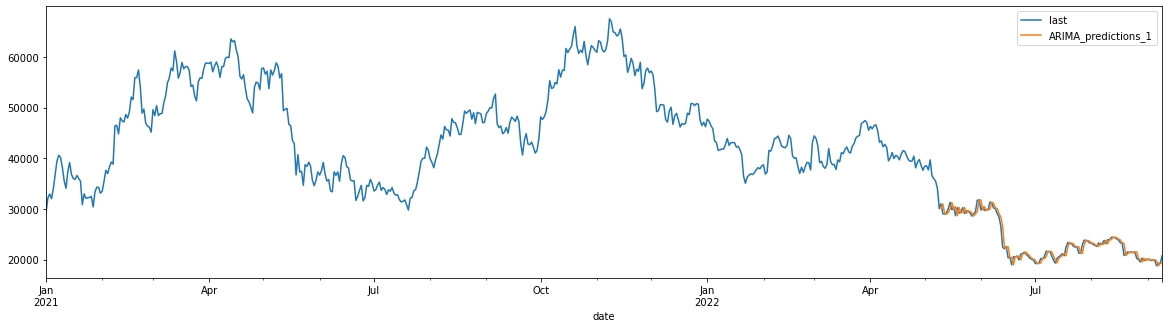

In [65]:
bitcoin_21_22[["last", "ARIMA_predictions_1"]].plot(figsize=(20, 5))

In [66]:
start = datetime.datetime.strptime("2022-09-10", "%Y-%m-%d")
date_list = [start + relativedelta(days = x) for x in range(0,12)]
future_prediction = pd.DataFrame(index = date_list, columns= bitcoin_21_22.columns)
bitcoin_last_pred = pd.concat([bitcoin_21_22, future_prediction])

In [67]:
bitcoin_last_pred

date     last   res_ARIMA_1  ARIMA_predictions_1
2021-01-01 2021-01-01  29359.9  29359.900000                  NaN
2021-01-02 2021-01-02  32193.3   2914.912180                  NaN
2021-01-03 2021-01-03  32958.9    774.764496                  NaN
2021-01-04 2021-01-04  32022.6   -933.575086                  NaN
2021-01-05 2021-01-05  33991.5   1965.298123                  NaN
...               ...      ...           ...                  ...
2022-09-17        NaT      NaN           NaN                  NaN
2022-09-18        NaT      NaN           NaN                  NaN
2022-09-19        NaT      NaN           NaN                  NaN
2022-09-20        NaT      NaN           NaN                  NaN
2022-09-21        NaT      NaN           NaN                  NaN

[629 rows x 4 columns]

In [68]:
len(bitcoin_21_22)

617

In [69]:
bitcoin_last_pred["future_prediction"] = ARIMA_fit_1.predict(start  = 617, end = 629, dynamic=True)

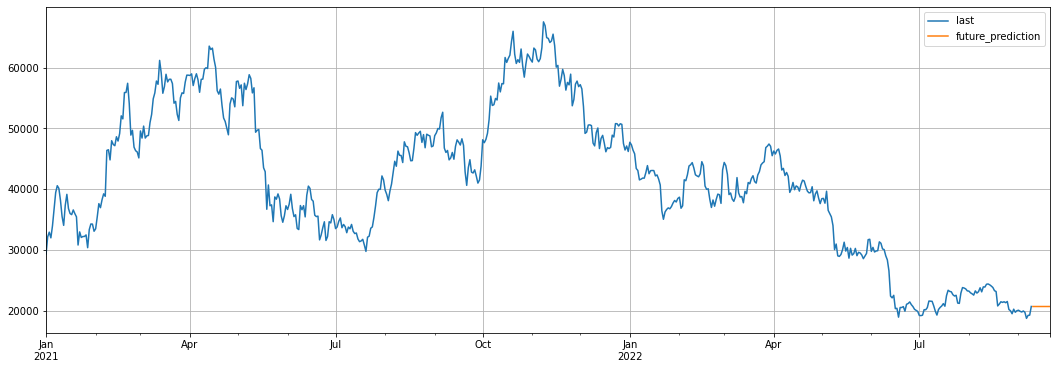

In [70]:
bitcoin_last_pred[["last","future_prediction"]].plot(figsize=(18, 6))
plt.grid(True)

In [71]:
bitcoin_last_pred

date     last   res_ARIMA_1  ARIMA_predictions_1  \
2021-01-01 2021-01-01  29359.9  29359.900000                  NaN   
2021-01-02 2021-01-02  32193.3   2914.912180                  NaN   
2021-01-03 2021-01-03  32958.9    774.764496                  NaN   
2021-01-04 2021-01-04  32022.6   -933.575086                  NaN   
2021-01-05 2021-01-05  33991.5   1965.298123                  NaN   
...               ...      ...           ...                  ...   
2022-09-17        NaT      NaN           NaN                  NaN   
2022-09-18        NaT      NaN           NaN                  NaN   
2022-09-19        NaT      NaN           NaN                  NaN   
2022-09-20        NaT      NaN           NaN                  NaN   
2022-09-21        NaT      NaN           NaN                  NaN   

            future_prediction  
2021-01-01                NaN  
2021-01-02                NaN  
2021-01-03                NaN  
2021-01-04                NaN  
2021-01-05                NaN  
...                       ...  
2022-09-17         20737.5208  
2022-09-18         20737.5208  
2022-09-19         20737.5208  
2022-09-20         20737.5208  
2022-09-21         20737.5208  

[629 rows x 5 columns]

In [72]:
bitcoin_last_pred_22 = bitcoin_last_pred["2022-01-01":]

In the plot below we see in more detail the evolution and prediction of year 2022

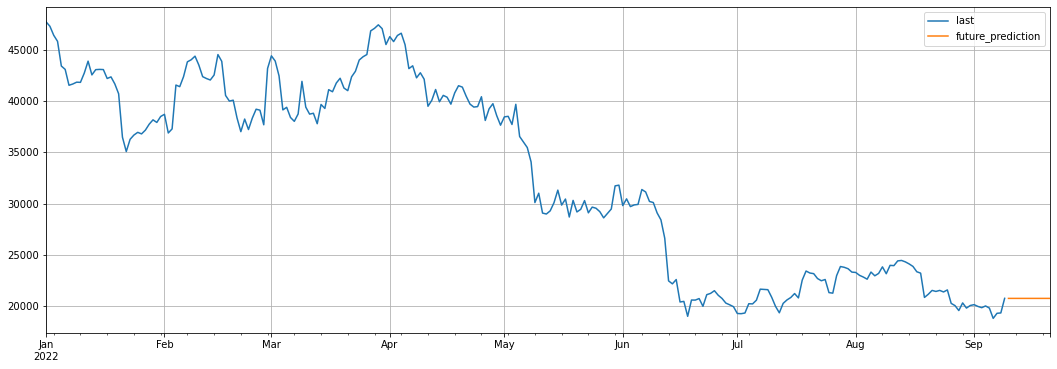

In [73]:
bitcoin_last_pred_22[["last","future_prediction"]].plot(figsize=(18, 6))
plt.grid(True)


##### Second model of ARIMA with wither time lapse data, trying to get better results

In [74]:
bitcoin_19_22 = bitcoin[bitcoin["date"] >= "2019-01-01"]
bitcoin_19_22 = bitcoin_19_22[["date", "last"]]

In [75]:
max_train_2 = math.ceil(len(bitcoin_19_22) * 0.80)  
max_train_2

1079

In [76]:
train_2 = bitcoin_19_22.iloc[:max_train_2,:]['last']
test_2  = bitcoin_19_22.iloc[max_train_2:,:]['last']

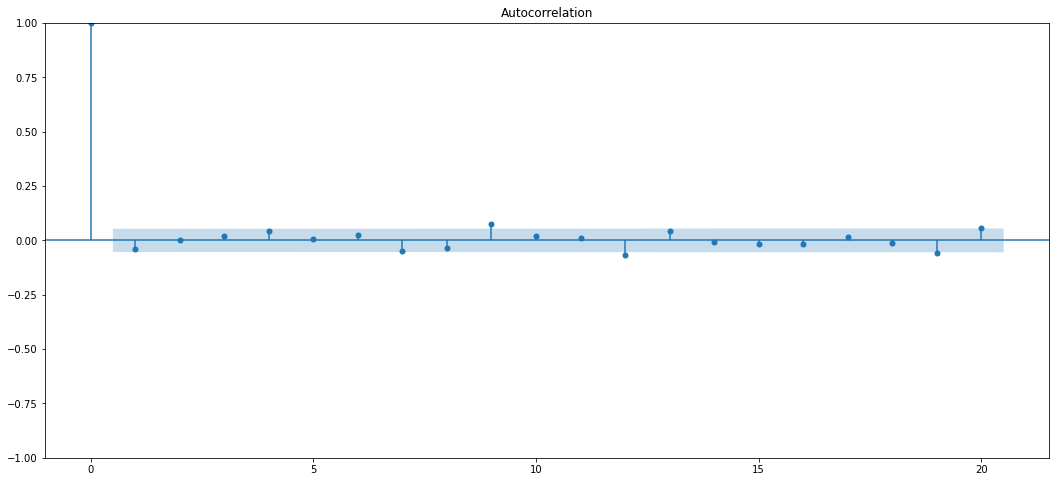

In [77]:
sm.graphics.tsa.plot_acf(bitcoin_19_22['last'].diff()[1:],
                        lags = 20)
plt.show()

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



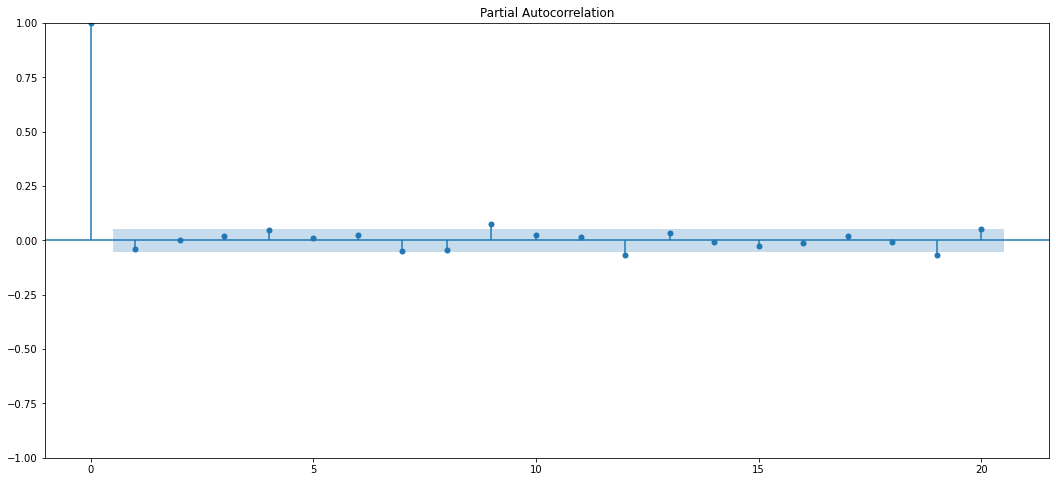

In [78]:
sm.graphics.tsa.plot_pacf(bitcoin_19_22['last'].diff()[1:],
                               lags = 20)
plt.show()

In [79]:
ARIMA_model2 = ARIMA(bitcoin_19_22["last"], order = (1, 1, 1), freq ="D")
ARIMA_fit_2 = ARIMA_model2.fit()
ARIMA_fit_2.summary()

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   last   No. Observations:                 1348
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11407.947
Date:                Tue, 13 Sep 2022   AIC                          22821.895
Time:                        16:06:20   BIC                          22837.512
Sample:                    01-01-2019   HQIC                         22827.744
                         - 09-09-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0500      0.480     -0.104      0.917      -0.991       0.891
ma.L1          0.0106      0.481      0.022      0.982      -0.932       0.953
sigma2      1.334e+06   2.44e+04     54.703      0.000    1.29e+06    1.38e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2902.44
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              17.19   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
with open("../models/ARIMA_model2.pkl", "wb") as file:
    pck.dump(ARIMA_model2,file)

In [81]:
ARIMA_predictions_2 = ARIMA_fit_2.predict(start = len(train_2), end = (len(train_2) + len(test_2) -1), dynamic=False)

In [82]:
bitcoin_19_22["ARIMA_predictions_2"] = ARIMA_predictions_2

<AxesSubplot:xlabel='date'>

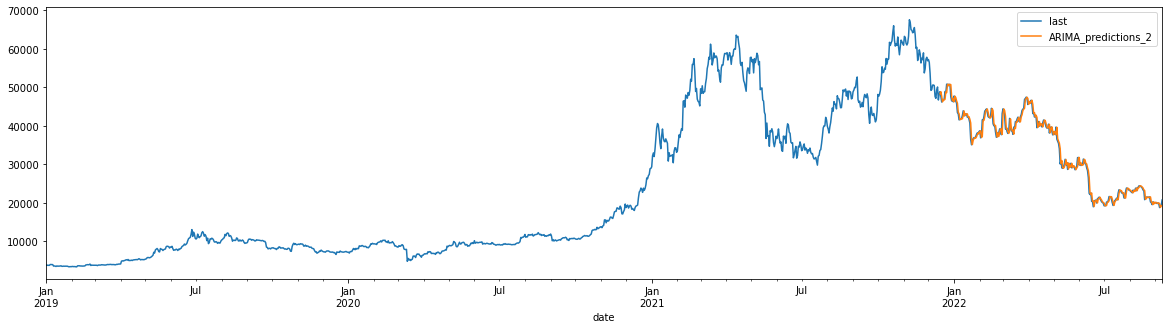

In [83]:
bitcoin_19_22[["last", "ARIMA_predictions_2"]].plot(figsize=(20, 5))

In [84]:
start = datetime.datetime.strptime("2022-09-10", "%Y-%m-%d")
date_list = [start + relativedelta(days = x) for x in range(0,12)]
future_prediction = pd.DataFrame(index = date_list, columns= bitcoin_19_22.columns)
bitcoin_19_22_pred = pd.concat([bitcoin_19_22, future_prediction])

In [85]:
bitcoin_19_22_pred["future_prediction"] = ARIMA_fit_2.predict(start  = 1348, end = 1360, dynamic=True)

In [86]:
bitcoin_19_22_pred

date    last  ARIMA_predictions_2  future_prediction
2019-01-01 2019-01-01  3809.4                  NaN                NaN
2019-01-02 2019-01-02  3873.8                  NaN                NaN
2019-01-03 2019-01-03  3780.1                  NaN                NaN
2019-01-04 2019-01-04  3802.7                  NaN                NaN
2019-01-05 2019-01-05  3785.4                  NaN                NaN
...               ...     ...                  ...                ...
2022-09-17        NaT     NaN                  NaN       20689.226065
2022-09-18        NaT     NaN                  NaN       20689.226065
2022-09-19        NaT     NaN                  NaN       20689.226065
2022-09-20        NaT     NaN                  NaN       20689.226065
2022-09-21        NaT     NaN                  NaN       20689.226065

[1360 rows x 4 columns]

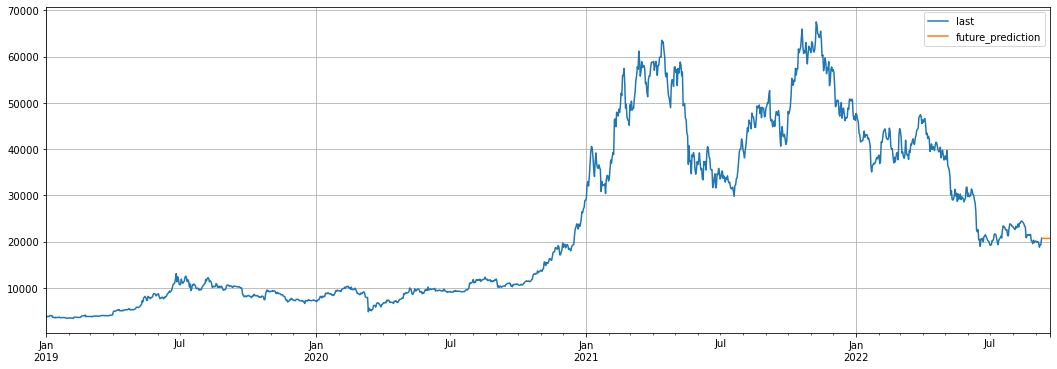

In [87]:
bitcoin_19_22_pred[["last","future_prediction"]].plot(figsize=(18, 6))
plt.grid(True)

In [88]:
test["ARIMA_predictions_1"] = ARIMA_predictions_1
test["res_ARIMA_1"] = ARIMA_fit_1.resid

In [89]:
test.head()

last  AR_predictions_1       AR_res  ARIMA_predictions_1  \
date                                                                      
2022-05-10  31007.5      30170.449850   837.050150         30109.927483   
2022-05-11  29068.2      31075.721911 -2007.521911         31003.752387   
2022-05-12  28976.0      29151.783162  -175.783162         29075.623675   
2022-05-13  29284.4      29060.313481   224.086519         28976.205951   
2022-05-14  30080.4      29366.270636   714.129364         29283.226981   

            res_ARIMA_1  
date                     
2022-05-10   897.572517  
2022-05-11 -1935.552387  
2022-05-12   -99.623675  
2022-05-13   308.194049  
2022-05-14   797.173019

##### Checking MASE for AR and ARIMA

In [90]:
test['1difference'] = np.abs(test['last'] - test['last'].shift(1))
quotient = test['1difference'].mean()
test['q'] = np.abs(test['AR_res'])/quotient
test.head()

last  AR_predictions_1       AR_res  ARIMA_predictions_1  \
date                                                                      
2022-05-10  31007.5      30170.449850   837.050150         30109.927483   
2022-05-11  29068.2      31075.721911 -2007.521911         31003.752387   
2022-05-12  28976.0      29151.783162  -175.783162         29075.623675   
2022-05-13  29284.4      29060.313481   224.086519         28976.205951   
2022-05-14  30080.4      29366.270636   714.129364         29283.226981   

            res_ARIMA_1  1difference         q  
date                                            
2022-05-10   897.572517          NaN  1.368332  
2022-05-11 -1935.552387       1939.3  3.281711  
2022-05-12   -99.623675         92.2  0.287354  
2022-05-13   308.194049        308.4  0.366316  
2022-05-14   797.173019        796.0  1.167392

## PROPHET 

In [91]:
bitcoin_21_22 = bitcoin[bitcoin["date"] >= "2021-01-01"]

In [92]:
bitcoin_21_22

date     last     open     high      low     vol  var_%
date                                                                    
2021-01-01 2021-01-01  29359.9  28951.7  29627.1  28712.4  100.90   1.42
2021-01-02 2021-01-02  32193.3  29359.7  33233.5  29008.0  240.87   9.65
2021-01-03 2021-01-03  32958.9  32192.9  34755.9  32029.6  155.21   2.38
2021-01-04 2021-01-04  32022.6  33016.6  33587.5  28204.5  255.27  -2.84
2021-01-05 2021-01-05  33991.5  32015.4  34414.7  30010.5  202.13   6.15
...               ...      ...      ...      ...      ...     ...    ...
2022-09-05 2022-09-05  19793.1  19999.9  20042.9  19650.7  238.71  -1.03
2022-09-06 2022-09-06  18786.4  19793.4  20169.3  18723.3  402.43  -5.09
2022-09-07 2022-09-07  19281.5  18786.3  19445.9  18548.4  319.10   2.64
2022-09-08 2022-09-08  19317.4  19281.5  19444.7  19034.5  291.43   0.19
2022-09-09 2022-09-09  20742.8  19318.8  20743.7  19294.1  359.40   7.38

[617 rows x 7 columns]

In [93]:
bitcoin_21_22_prophet = bitcoin_21_22[["last", "date"]].rename(columns = {"last": 'y', "date": "ds"})

In [94]:
bitcoin_21_22_prophet.head()

y         ds
date                          
2021-01-01  29359.9 2021-01-01
2021-01-02  32193.3 2021-01-02
2021-01-03  32958.9 2021-01-03
2021-01-04  32022.6 2021-01-04
2021-01-05  33991.5 2021-01-05

In [95]:
bitcoin_fbp = Prophet()
with open("../models/bitcoin_fbp.pkl", "wb") as file:
    pck.dump(bitcoin_fbp,file)

    bitcoin_fbp.fit(bitcoin_21_22_prophet)

bitcoin_prophet = bitcoin_fbp.make_future_dataframe(periods = 120, freq = "D")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



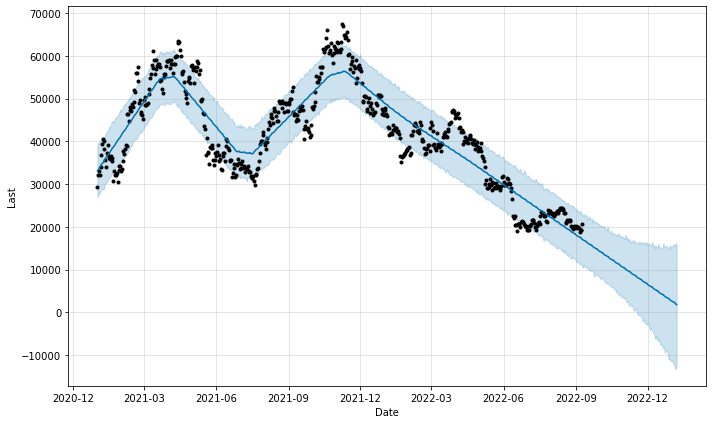

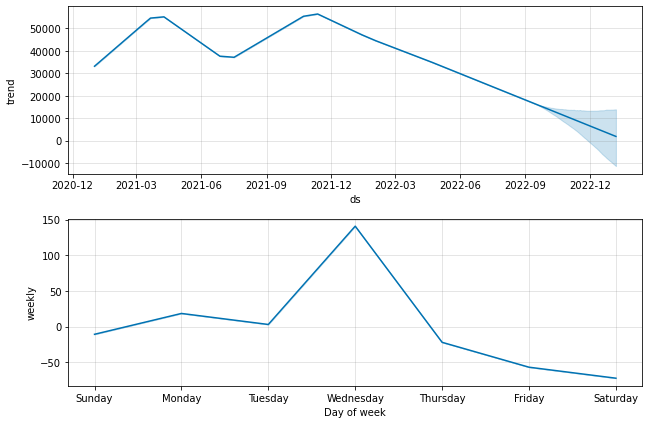

In [96]:
bitcoin_prophet_future = bitcoin_fbp.predict(bitcoin_prophet)

bitcoin_fbp.plot(bitcoin_prophet_future, xlabel = 'Date', ylabel = 'Last')
fig = bitcoin_fbp.plot_components(bitcoin_prophet_future)
plt.show()

In the first plot: 
    
    - Black dots show the real data that we have in the original Dataset 
    
    - Blue line is the forecasted data, the data predicted. 

As we can see the predictions show that the price of Bitcoin will drop in the following months

In [97]:
len(bitcoin_21_22)

617

In [98]:
fbp_cv = cross_validation(bitcoin_fbp, initial = '617', period = '120 days', horizon = '365 days',
                         parallel="processes")
fbp_cv.head()

INFO:prophet:Making 3 forecasts with cutoffs between 2021-01-12 00:00:00 and 2021-09-09 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002402AC015B0>


ds          yhat    yhat_lower    yhat_upper        y     cutoff
0 2021-01-13  42394.139714  40026.142631  44623.344158  37382.2 2021-01-12
1 2021-01-14  45059.206766  42665.374968  47155.720510  39175.7 2021-01-12
2 2021-01-15  43384.595612  41127.676198  45625.161975  36845.8 2021-01-12
3 2021-01-16  44575.896872  42311.451695  46654.070070  36019.5 2021-01-12
4 2021-01-17  43977.686854  41808.462463  46309.392184  35839.6 2021-01-12

In [99]:
#checking performance metrics for ERROR

bitcoin_prophet_future_pm = performance_metrics(fbp_cv)

In [100]:
bitcoin_prophet_future_pm

horizon           mse           rmse            mae      mape     mdape  \
0    37 days  2.343130e+08   15307.284520   13986.622496  0.358702  0.366443   
1    38 days  2.391222e+08   15463.577724   14145.978054  0.362630  0.374419   
2    39 days  2.436844e+08   15610.393994   14285.483426  0.365950  0.374974   
3    40 days  2.488141e+08   15773.843074   14426.150844  0.370016  0.377531   
4    41 days  2.537633e+08   15929.951067   14573.247927  0.373874  0.388532   
..       ...           ...            ...            ...       ...       ...   
324 361 days  2.940725e+10  171485.420519  134282.931618  3.899492  5.286174   
325 362 days  2.962605e+10  172122.190571  134893.125621  3.940548  5.306082   
326 363 days  2.982809e+10  172708.099633  135466.778343  3.977202  5.317301   
327 364 days  3.003689e+10  173311.548205  136062.320719  4.013638  5.326265   
328 365 days  3.026983e+10  173982.279663  136679.237329  4.044118  5.335399   

        smape  coverage  
0    0.293127  0.100917  
1    0.295860  0.110092  
2    0.298098  0.119266  
3    0.300554  0.128440  
4    0.302994  0.137615  
..        ...       ...  
324  1.038481  0.333333  
325  1.044393  0.333333  
326  1.049876  0.333333  
327  1.055732  0.333333  
328  1.060956  0.333333  

[329 rows x 8 columns]

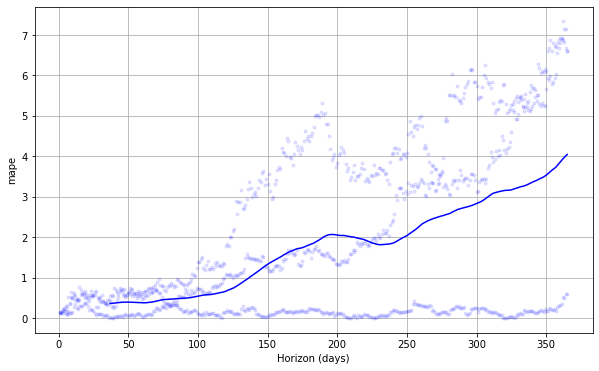

In [101]:
fig = plot_cross_validation_metric(fbp_cv, metric = 'mape')

Here we see error metric MAPE through the days prediccted in the future. The blue line represents the MAPE that tends to increase as the time goes by. 